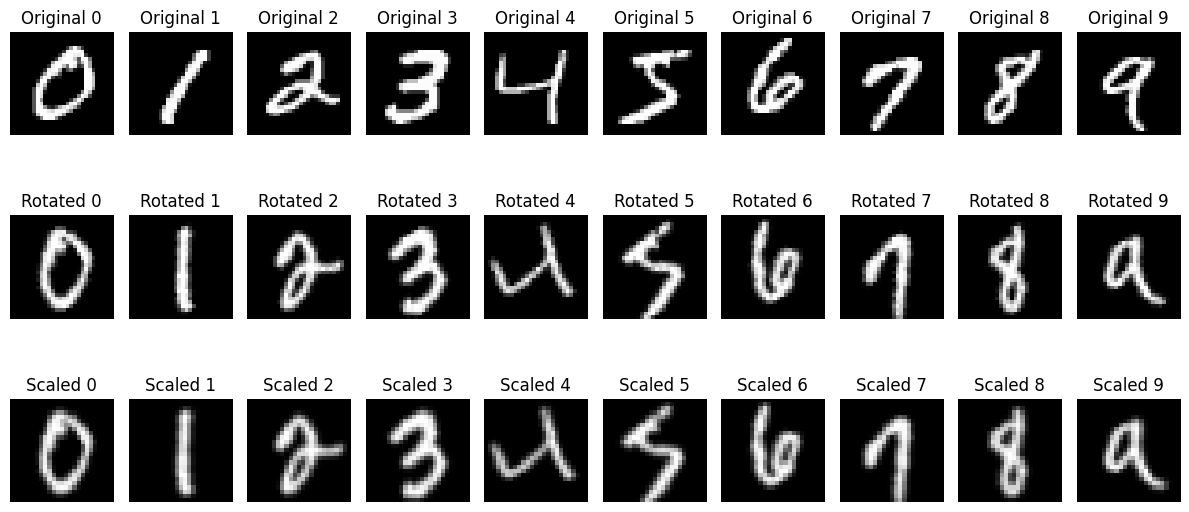

{'freeman': {'original': [[], [], [], [], [], [], [], [], [], []],
  'rotated': [[], [], [], [], [], [], [], [], [], []],
  'scaled': [[], [], [], [], [], [], [], [], [], []]},
 'fourier': {'original': [array([-2.50326286e+00, -9.23043007e+00,  6.53155090e+00, -9.60853118e+00,
           4.65150633e-01, -1.07793150e+01,  1.38950697e+01,  1.33811243e+01,
           1.72605239e+01,  1.60148581e+01, -2.73176579e+01,  1.53151584e+01,
           1.80839453e+01, -2.00592892e+00,  5.81237864e+00, -2.00592892e+00,
           1.80839453e+01,  1.53151584e+01, -2.73176579e+01,  1.60148581e+01,
           1.72605239e+01,  1.33811243e+01,  1.38950697e+01, -1.07793150e+01,
           4.65150633e-01, -9.60853118e+00,  6.53155090e+00, -9.23043007e+00,
           1.49526102e+01,  6.85298835e+00, -8.71395881e+00, -7.00022738e-02,
           1.53466205e+01,  1.40845246e+01, -1.73733888e+00, -7.84752448e+00,
          -1.40684242e+01,  1.10220675e+01,  2.17681054e+01,  1.93067940e+01,
           1.8089046

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import feature
from numpy.fft import fft2, fftshift
import cv2

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Select one sample image from each class (digit) for demonstration purposes
unique_digits = np.unique(y_train)
subset_indices = [np.where(y_train == digit)[0][0] for digit in unique_digits]
subset_images = x_train[subset_indices]

# Function to apply rotation and scaling transformations
def apply_transformations(image, angle=30, scale=0.9):
    # Rotate the image
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)

    # Scale the image
    scaled_image = cv2.resize(rotated_image, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

    return rotated_image, scaled_image

# Function to compute the Fourier descriptors of an image
def compute_fourier_descriptors(image):
    # Apply 2D fast Fourier transform
    f_transform = fft2(image)
    # Shift the zero frequency component to the center of the spectrum
    f_shifted = fftshift(f_transform)
    # Compute the magnitude spectrum
    magnitude_spectrum = 20 * np.log(np.abs(f_shifted))
    return magnitude_spectrum.flatten()

def freeman_chain_code(edges):
    # Find contours in the edge image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if contours:
        # Extract the longest contour
        longest_contour = max(contours, key=cv2.contourArea)
        # Compute the Freeman chain code
        chain_code = []
        for i in range(1, len(longest_contour)):
            point = longest_contour[i][0]
            prev_point = longest_contour[i - 1][0]
            direction = (point[0] - prev_point[0], point[1] - prev_point[1])
            chain_code.append(direction)
        return chain_code
    else:
        return []

# Process the images and generate descriptors
processed_images = {'original': [], 'rotated': [], 'scaled': []}
descriptors = {'freeman': {'original': [], 'rotated': [], 'scaled': []},
               'fourier': {'original': [], 'rotated': [], 'scaled': []}}

# Apply transformations and compute descriptors
for image in subset_images:
    rotated_image, scaled_image = apply_transformations(image)
    processed_images['original'].append(image)
    processed_images['rotated'].append(rotated_image)
    processed_images['scaled'].append(scaled_image)
    
    # Compute Freeman chain code descriptors for the original, rotated, and scaled images
    original_edges = detect_edges(image)
    rotated_edges = detect_edges(rotated_image)
    scaled_edges = detect_edges(scaled_image)
    
    descriptors['freeman']['original'].append(freeman_chain_code(original_edges))
    descriptors['freeman']['rotated'].append(freeman_chain_code(rotated_edges))
    descriptors['freeman']['scaled'].append(freeman_chain_code(scaled_edges))
    
    # Compute Fourier descriptors for each set of images
    descriptors['fourier']['original'].append(compute_fourier_descriptors(image))
    descriptors['fourier']['rotated'].append(compute_fourier_descriptors(rotated_image))
    descriptors['fourier']['scaled'].append(compute_fourier_descriptors(scaled_image))

# Visualization and further analysis would follow...

# Display the images and their transformations
fig, axes = plt.subplots(3, len(subset_images), figsize=(12, 6))
for i, digit in enumerate(unique_digits):
    axes[0, i].imshow(processed_images['original'][i], cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Original {digit}')
    
    axes[1, i].imshow(processed_images['rotated'][i], cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Rotated {digit}')
    
    axes[2, i].imshow(processed_images['scaled'][i], cmap='gray')
    axes[2, i].axis('off')
    axes[2, i].set_title(f'Scaled {digit}')

plt.tight_layout()
plt.show()

# Return the descriptors for further analysis
descriptors